## Library

In [160]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import copy 
from IPython.display import clear_output
import time

## Prepare a set of random data for a binary classification problem

In [186]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 

X_test = X[900:]
y_test = y[900:]
X = X[:900]
y = y[:900]


print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

X shape: (100, 2)
y shape: (100,)


## 3D Scatter Plot

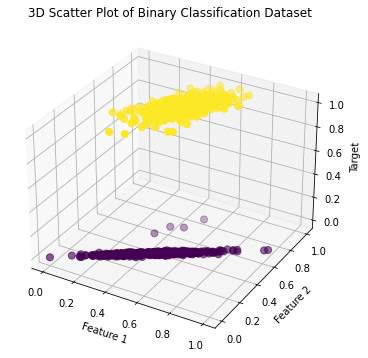

In [65]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

feature1 = X[:, 0]
feature2 = X[:, 1]
ax.scatter(feature1, feature2, y, c=y, cmap='viridis', s=50)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')

plt.title('3D Scatter Plot of Binary Classification Dataset')
plt.show()

## Model

In [162]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.layer1 = nn.Linear(input_shape[0], 8, bias=True)
        self.layer2 = nn.Linear(8, 16, bias=True)
        self.layer3 = nn.Linear(16, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer3(x))

        return x

## Node(Worker)

In [163]:
class Node():
    batch_size = 8

    def __init__(self, model, X, y, x_test, y_test):
        self.train_loader = self.preparData(X, y)
        self.criterion = nn.MSELoss()
        self.model = model
        self.hist = []
        self.test_loader = self.preparData(x_test, y_test) 

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader
    
    def count_loss(self):
        outputs = self.model(self.test_loader.dataset.tensors[0]) 
        loss = self.criterion(outputs, self.test_loader.dataset.tensors[1])
        print(loss.item()) 
    
    def run(self, batch):  
        outputs = self.model(self.train_loader.dataset.tensors[0][batch*self.batch_size:batch*self.batch_size + self.batch_size])
        loss = self.criterion(outputs, self.train_loader.dataset.tensors[1][batch*self.batch_size:batch*self.batch_size + self.batch_size]) 
        loss.backward()
        self.hist.append(loss.item())

        return [param.grad.clone() for param in self.model.parameters()]

## Central Node

In [198]:
%clear

class Central():
    num_epochs = 20
    lr = 0.001
    batch_size = 8

    def __init__(self, X, y, x_test, y_test, num_workers=3):
        self.model = Model(input_shape=(2,))
        self.num_workers = num_workers
        self.dataset = self.devideData(X, y)
        self.workers = [Node(copy.deepcopy(self.model), self.dataset[0][i], self.dataset[1][i], x_test, y_test) for i in range(num_workers)]
        self.criterion = nn.MSELoss()
        self.train_loader = self.preparData(X, y) 
        self.test_loader = self.preparData(x_test, y_test) 
        self.hist = []
        self.avgLoss = []
        

    def preparData(self, X, y):
        y = y.reshape((y.shape[0], 1))
        X = torch.tensor(X)
        y = torch.tensor(y)
        X = X.float()
        y = y.float()
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
        return data_loader

    def devideData(self, X, y):
        l_x = []
        l_y = []
        for i in range(self.num_workers):
            l_x.append(X[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
            l_y.append(y[i* (X.shape[0]//self.num_workers): ((i+1) * (X.shape[0]//self.num_workers))])
        return l_x, l_y
    
    def count_loss(self):
        outputs = self.model(self.test_loader.dataset.tensors[0]) 
        loss = self.criterion(outputs, self.test_loader.dataset.tensors[1])
        print(loss.item()) 
    
    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for i in range(self.workers[0].train_loader.dataset.tensors[0].shape[0] // self.workers[0].batch_size): 
                grads = []
                for e, worker in enumerate(self.workers):
                    grads.append(worker.run(i))
                    print(f'Worker {e} was send its gradient on the batch number {i}!')
                    time.sleep(0.5)

                grad_agr= []
                for i in range(len(list(self.workers[0].model.parameters()))):
                    elem = 0
                    for grad in grads:
                        elem += grad[i]
                    grad_agr.append(elem)
                
                with torch.no_grad():
                    for p, g in zip(self.model.parameters(), grad_agr):
                        p -= self.lr * g
                print("Global model updated!")
                time.sleep(0.7)
                for worker in self.workers:
                    with torch.no_grad():
                        for param_src, param_dst in zip(self.model.parameters(), worker.model.parameters()):
                            param_dst.copy_(param_src)
                
                print("Local models updated!")
                time.sleep(0.7)
                clear_output(wait=True)

                input_batch = self.train_loader.dataset.tensors[0][i*self.batch_size: i*self.batch_size + self.batch_size]
                y_act_batch = self.train_loader.dataset.tensors[1][i*self.batch_size: i*self.batch_size + self.batch_size]

                outputs = self.model(input_batch) 
                loss = self.criterion(outputs, y_act_batch) 
                self.hist.append(loss.item())
                
                total_loss += loss.item()

            self.avg_loss = total_loss / (len(self.workers[0].train_loader) // self.num_workers)
            self.avgLoss.append(self.avg_loss)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {self.avg_loss}")
            time.sleep(0.2)

## Initiate the setting

In [249]:
central = Central(X, y, X_test, y_test, num_workers=3)

C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\3089847764.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\3089847764.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\2813670819.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\2813670819.py:23: UserWarning: To copy construct from a tensor, it is recommended to

#### Count Loss before training

In [250]:
central.count_loss() 

0.2512494921684265


In [251]:
central.train()

Epoch 1/20, Loss: 0.7778747826814651
Epoch 2/20, Loss: 0.7721829737226168
Epoch 3/20, Loss: 0.7759711816906929
Epoch 4/20, Loss: 0.7716947756707668
Epoch 5/20, Loss: 0.7610413519044718
Epoch 6/20, Loss: 0.7575572865704695
Epoch 7/20, Loss: 0.7374613918364048
Epoch 8/20, Loss: 0.6912850278119246
Epoch 9/20, Loss: 0.5834366157650948
Epoch 10/20, Loss: 0.3912392407655716
Epoch 11/20, Loss: 0.21770893534024557
Epoch 12/20, Loss: 0.10506893694400787
Epoch 13/20, Loss: 0.0746130269059601
Epoch 14/20, Loss: 0.0002714200147693191
Epoch 15/20, Loss: 3.3155479769083246e-07
Epoch 16/20, Loss: 1.4073747243159573e-05
Epoch 17/20, Loss: 4.213374662964675e-05
Epoch 18/20, Loss: 1.8150294550557465e-20
Epoch 19/20, Loss: 1.6274385023660854e-20
Epoch 20/20, Loss: 1.6012301488591265e-28


#### Count loss after training

In [252]:
central.count_loss()

0.009999999776482582


## Multi-Worker Training: Comparative Analysis of Loss Function Histories

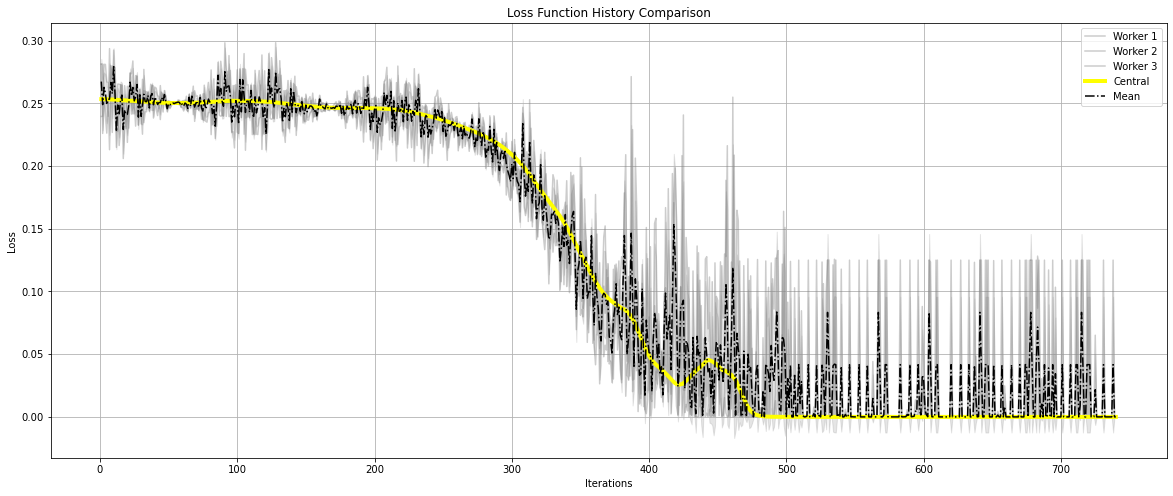

In [253]:
import matplotlib.pyplot as plt

loss_history_model1 = central.workers[0].hist
loss_history_model2 = central.workers[1].hist
loss_history_model3 = central.workers[2].hist
loss_history_model4 = central.hist

epochs = list(range(1, len(loss_history_model1) + 1))

plt.figure(figsize=(20, 8))

plt.plot(epochs, central.workers[0].hist, color='grey', label='Worker 1', alpha=0.4)
plt.plot(epochs, central.workers[1].hist, color='grey', label='Worker 2', alpha=0.4)
plt.plot(epochs, central.workers[2].hist, color='grey', label='Worker 3', alpha=0.4)
plt.plot(epochs, central.hist, color='yellow', label='Central', alpha=1, linewidth=4)

mean_loss = [sum(x) / len(x) for x in zip(loss_history_model1, loss_history_model2, loss_history_model3)]
plt.plot(epochs, mean_loss, label='Mean', color='black', linestyle='-.', linewidth=1.5)

std_dev = [np.std(x) for x in zip(loss_history_model1, loss_history_model2, loss_history_model3, loss_history_model4)]
plt.fill_between(epochs, [m - s for m, s in zip(mean_loss, std_dev)], [m + s for m, s in zip(mean_loss, std_dev)], color='gray', alpha=0.2)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Function History Comparison')
plt.grid()
plt.legend()

plt.show()

In [254]:
distLoss = central.avgLoss

# Normal training

In [265]:
import torch.optim as optim

model = Model(input_shape=(2,))
num_epochs = 20
lr = 0.001
batch_size = 8
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


y = y.reshape((y.shape[0], 1))
X = torch.tensor(X)
y = torch.tensor(y)
X = X.float()
y = y.float()

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\2333688616.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\etabook\AppData\Local\Temp\ipykernel_17792\2333688616.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [266]:
normalLoss = []
for epoch in range(num_epochs):
    model.train()  

    for inputs, targets in data_loader:
        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()  
        optimizer.step()  
    normalLoss.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.2552
Epoch [2/20], Loss: 0.2952
Epoch [3/20], Loss: 0.2574
Epoch [4/20], Loss: 0.2582
Epoch [5/20], Loss: 0.2566
Epoch [6/20], Loss: 0.1882
Epoch [7/20], Loss: 0.2543
Epoch [8/20], Loss: 0.2536
Epoch [9/20], Loss: 0.2539
Epoch [10/20], Loss: 0.2550
Epoch [11/20], Loss: 0.2555
Epoch [12/20], Loss: 0.2531
Epoch [13/20], Loss: 0.2019
Epoch [14/20], Loss: 0.2777
Epoch [15/20], Loss: 0.2761
Epoch [16/20], Loss: 0.2526
Epoch [17/20], Loss: 0.2735
Epoch [18/20], Loss: 0.2292
Epoch [19/20], Loss: 0.2525
Epoch [20/20], Loss: 0.2304


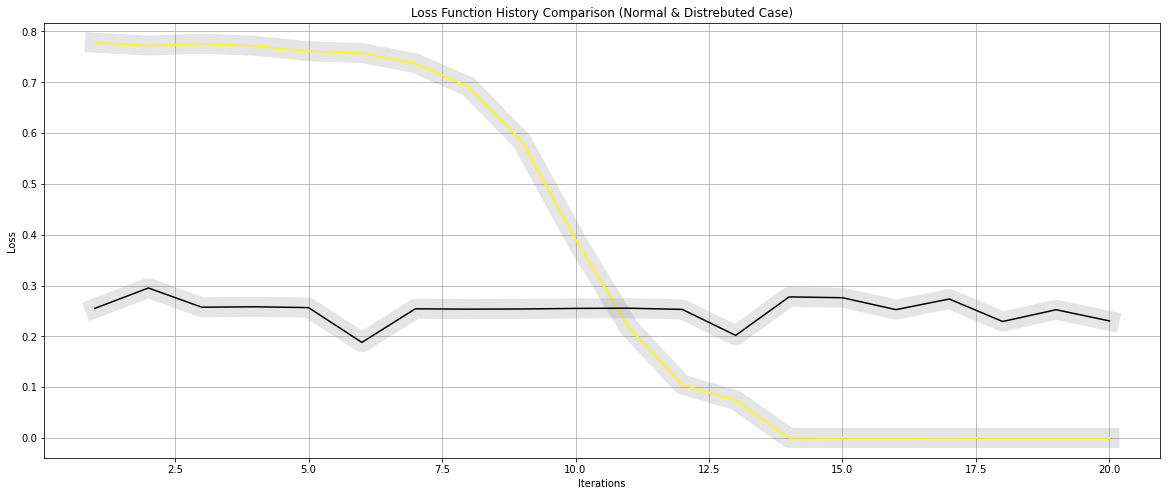

In [268]:
epochs = list(range(1, len(distLoss) + 1))

plt.figure(figsize=(20, 8))

plt.plot(epochs, distLoss, color='grey', label='abc', alpha=0.2, linewidth=20)[0]
plt.plot(epochs, distLoss, color='yellow', label='Distrebuted case', alpha=1)
plt.plot(epochs, normalLoss, color='grey', label='b', alpha=0.2, linewidth=20)
plt.plot(epochs, normalLoss, color='black', label='Normal case', alpha=1)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Function History Comparison (Normal & Distrebuted Case)')
plt.grid()
plt.show()